**Data Loading Pipeline**
- SHD kommt von Peter... Speech Command dataset
- SHD hat keine möglichkeit auf Rückführung
- SHD benutzt Lyon's Cochlea Model
- ursprung ist speech command dataset


In [7]:
import torchaudio

dataset = torchaudio.datasets.SPEECHCOMMANDS(
    root='./data', 
    download=True
)

In [6]:
import tonic
dataset_SHD = tonic.datasets.SHD(save_to="./data", train=False)
spike_events, label = dataset_SHD[1]

In [8]:
waveform, sample_rate, label, speaker_id, utterance_number = dataset[0]


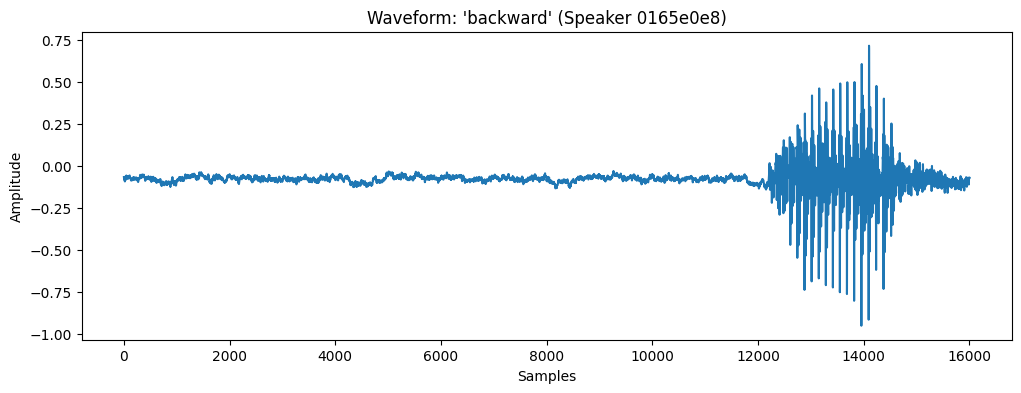

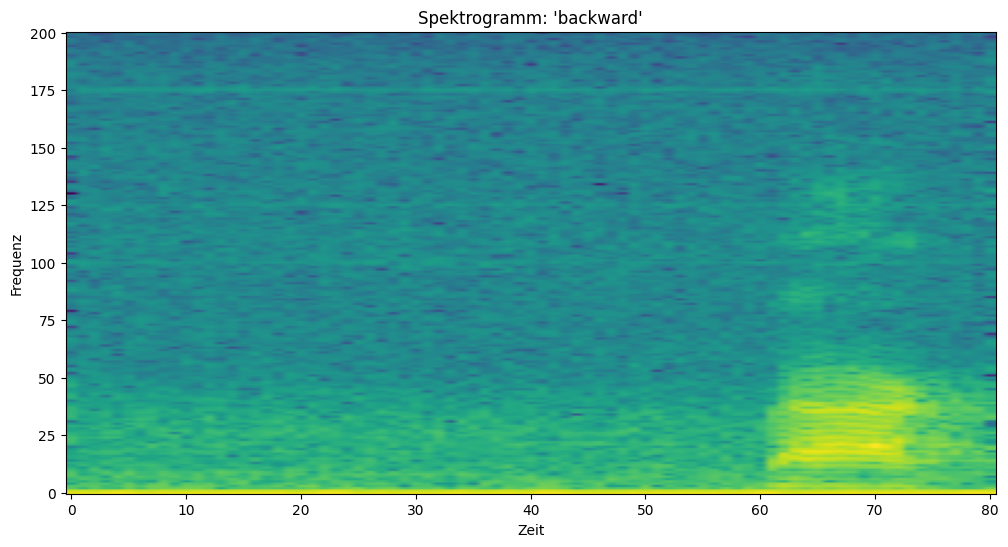

Label: backward
Shape: torch.Size([1, 16000])
Sample Rate: 16000
Duration: 1.00s


In [14]:
import matplotlib.pyplot as plt

# 1. Waveform
plt.figure(figsize=(12, 4))
plt.plot(waveform[0])  # Mono-Kanal
plt.title(f"Waveform: '{label}' (Speaker {speaker_id})")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

# 2. Spektrogramm
plt.figure(figsize=(12, 6))
spec = torchaudio.transforms.Spectrogram()(waveform)
plt.imshow(spec[0].log().numpy(), aspect='auto', origin='lower')
plt.title(f"Spektrogramm: '{label}'")
plt.xlabel("Zeit")
plt.ylabel("Frequenz")
plt.show()

# 3. Audio abspielen
from IPython.display import Audio
Audio(waveform.numpy(), rate=sample_rate)
print(f"Label: {label}")
print(f"Shape: {waveform.shape}")
print(f"Sample Rate: {sample_rate}")
print(f"Duration: {waveform.shape[1]/sample_rate:.2f}s")

In [15]:
import tonic.transforms as transforms
import torch

# 1. Cochleagram (wie SHD)
cochlea_transform = transforms.ToFrame(
    sensor_size=(700, 1, 1),  # 700 Cochlea-Kanäle
    time_window=1000  # 1ms Zeitfenster
)

# 2. Audio → Events
waveform, sample_rate, label, speaker_id, utterance_number = dataset[0]

# Resample zu 16kHz (wie SHD)
if sample_rate != 16000:
    resampler = torchaudio.transforms.Resample(sample_rate, 16000)
    waveform = resampler(waveform)

# 3. Zu Events konvertieren
# (Vereinfachter Ansatz - echtes Cochlea-Model komplexer)
spectrogram = torchaudio.transforms.Spectrogram(n_fft=512)(waveform)
events = []

for t_idx, frame in enumerate(spectrogram[0].T):
    for freq_idx, magnitude in enumerate(frame[:700]):  # Max 700 Kanäle
        if magnitude > 0.3:  # Schwellwert
            events.append([t_idx * 1000, freq_idx, 1])  # Zeit, Kanal, Polarität

events = torch.tensor(events)

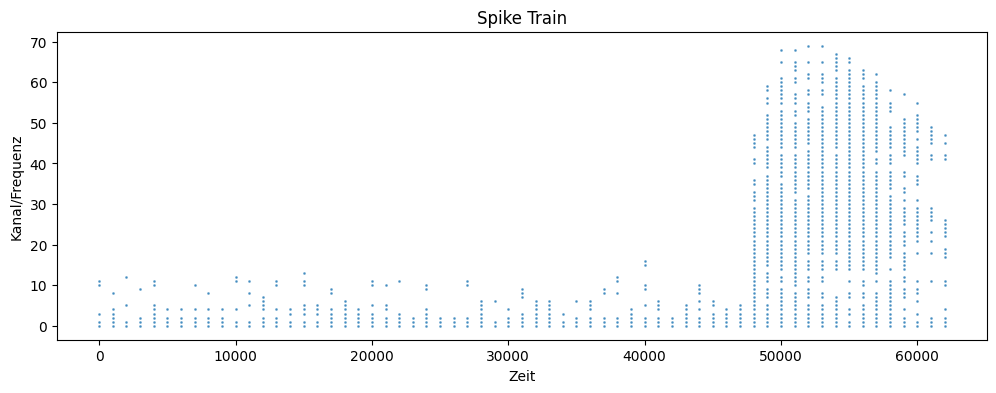

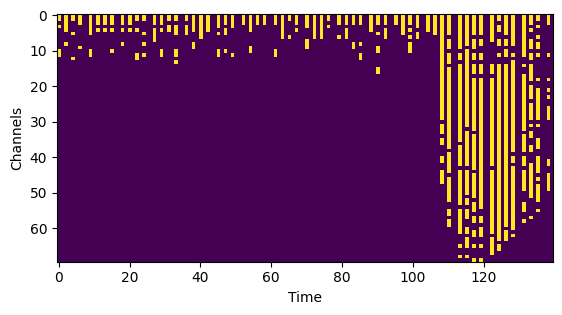

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Option 1: Manuell plotten
plt.figure(figsize=(12, 4))
plt.scatter(events[:, 0], events[:, 1], s=1, alpha=0.6)
plt.xlabel('Zeit')
plt.ylabel('Kanal/Frequenz')
plt.title('Spike Train')
plt.show()

# Option 2: Zu tonic-Format konvertieren
events_numpy = np.array([
    (t, x, p) for t, x, p in events.numpy()
], dtype=[('t', np.int64), ('x', np.int64), ('p', np.int64)])

# Dann plotten
tonic.utils.plot_event_grid(events_numpy)

Skalierte Matrix: 785 x 700


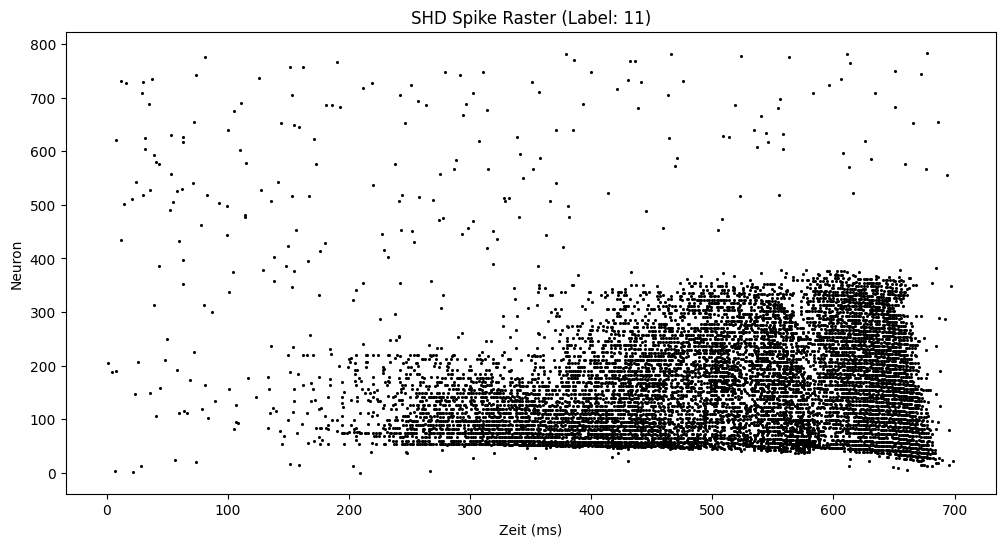

In [24]:
import snntorch.spikeplot as splt
import matplotlib.pyplot as plt
import tonic
import torch

dataset_SHD = tonic.datasets.SHD(save_to="./data", train=False)
spike_events, label = dataset_SHD[1]

# Zeit von Mikrosekunden zu Millisekunden (oder Bins)
time_scale = 1000  # Teile durch 1000 (μs → ms)
time_bins = 1000   # Oder fixe Anzahl Bins

# Skaliere Zeit runter
scaled_times = spike_events['t'] // time_scale
num_steps = min(scaled_times.max() + 1, time_bins)
num_neurons = spike_events['x'].max() + 1

print(f"Skalierte Matrix: {num_steps} x {num_neurons}")

# Sparse zu dense Matrix
spike_data = torch.zeros(num_steps, num_neurons)
for event in spike_events:
    t_scaled = int(event['t'] // time_scale)
    neuron = int(event['x'])
    if t_scaled < num_steps:
        spike_data[t_scaled, neuron] = 1

# Raster plot
fig, ax = plt.subplots(figsize=(12, 6))
splt.raster(spike_data.T, ax, s=1.5, c="black")
ax.set_xlabel("Zeit (ms)")
ax.set_ylabel("Neuron")
ax.set_title(f'SHD Spike Raster (Label: {label})')
plt.show()

(array([ 1.,  1.,  2.,  1.,  2.,  7.,  9.,  7., 11.,  9., 10.,  7.,  8.,
         6.,  7.,  6.,  5.,  0.,  0.,  1.]),
 array([ 431.64   ,  460.49745,  489.3549 ,  518.21235,  547.0698 ,
         575.92725,  604.7847 ,  633.64215,  662.4996 ,  691.35705,
         720.2145 ,  749.07195,  777.9294 ,  806.78685,  835.6443 ,
         864.50175,  893.3592 ,  922.21665,  951.0741 ,  979.93155,
        1008.789  ]),
 <BarContainer object of 20 artists>)

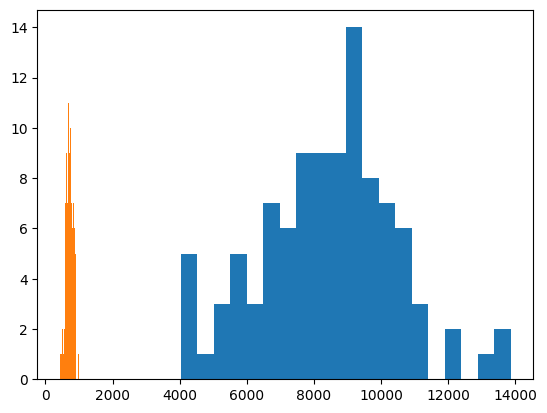

In [26]:
# Pro Sample
events_per_sample = [len(dataset_SHD[i][0]) for i in range(100)]
durations = [(dataset_SHD[i][0]['t'].max() - dataset_SHD[i][0]['t'].min())/1000 for i in range(100)]
plt.hist(events_per_sample, bins=20)
plt.hist(durations, bins=20)  # in ms

In [31]:
# Synchrony - wie viele Neuronen gleichzeitig aktiv
time_bins = np.histogram(spike_events['t'], bins=100)[0]
population_sync = np.std(time_bins) / np.mean(time_bins)  # CV
print(f"Population Sync: {population_sync:.2f}")

Population Sync: 1.31


In [33]:
# Frequenz-Verteilung über Cochlea-Kanäle
channel_activity = np.bincount(spike_events['x'], minlength=700)
# Dominante Frequenzbänder
dominant_channels = np.where(channel_activity > np.percentile(channel_activity, 90))[0]

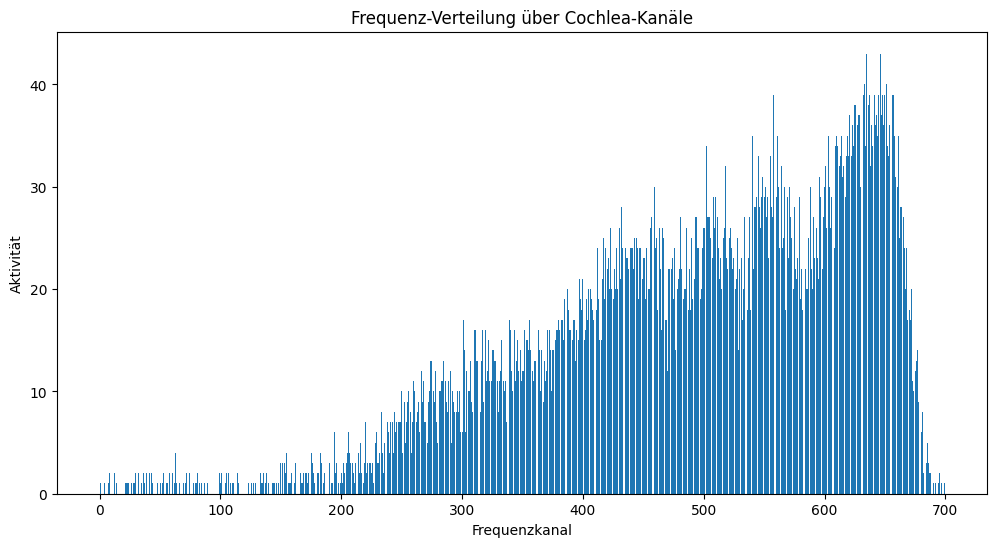

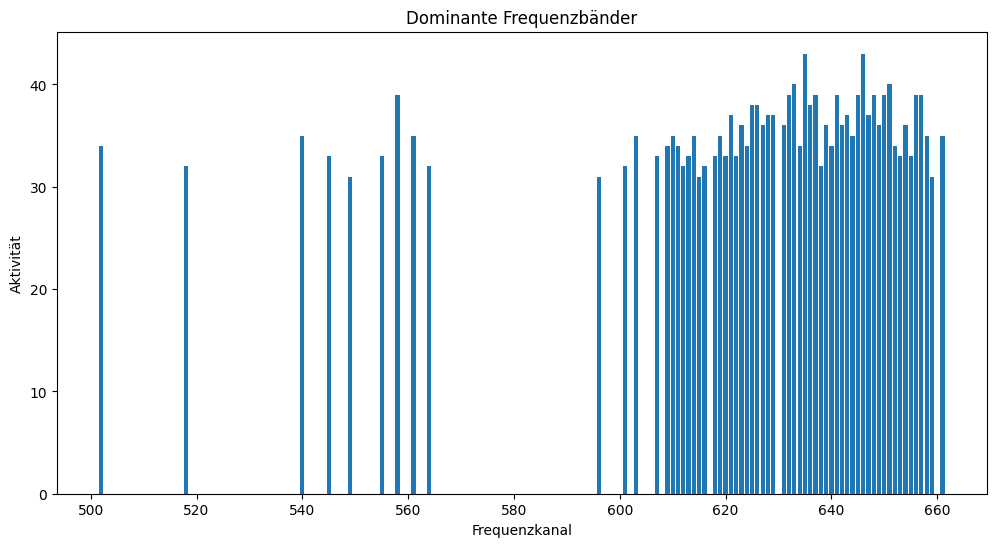

In [37]:
#visualieren
plt.figure(figsize=(12, 6))
plt.bar(range(700), channel_activity)
plt.xlabel("Frequenzkanal")
plt.ylabel("Aktivität")
plt.title("Frequenz-Verteilung über Cochlea-Kanäle")
plt.show()
#dominant channels visualieren
plt.figure(figsize=(12, 6))
plt.bar(dominant_channels, channel_activity[dominant_channels])
plt.xlabel("Frequenzkanal")
plt.ylabel("Aktivität")
plt.title("Dominante Frequenzbänder")
plt.show()

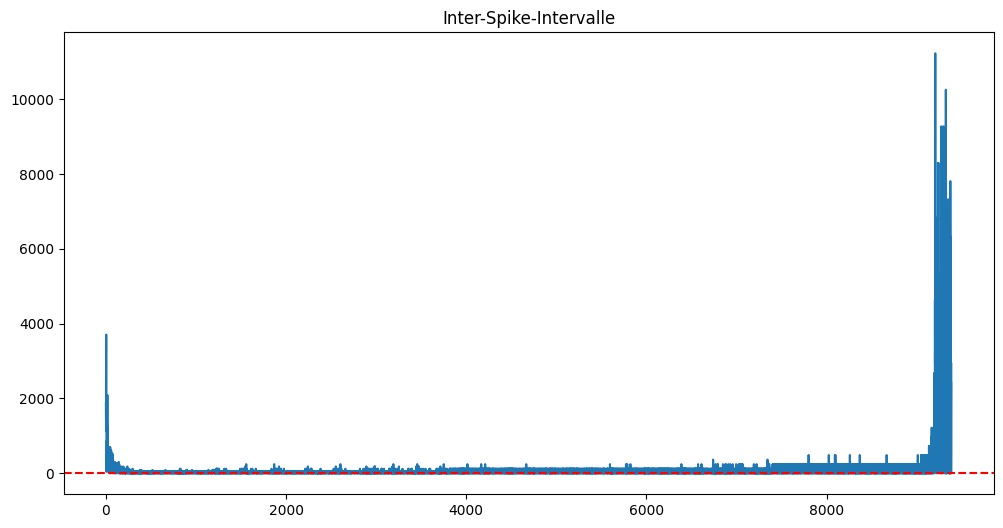

In [40]:
# Inter-Spike-Intervalle
isi = np.diff(np.sort(spike_events['t']))
cv_isi = np.std(isi) / np.mean(isi)  # Coefficient of Variation

# Burst-Erkennung
burst_threshold = np.percentile(isi, 10)
bursts = isi < burst_threshold

#visualisieren
plt.figure(figsize=(12, 6))
plt.plot(isi)
plt.axhline(burst_threshold, color='r', linestyle='--')
plt.title("Inter-Spike-Intervalle")
plt.show()
